# 1. Data Collection & Preprocessing

@techietrader

The idea is to try finding those stocks which belong to same clusters irrespective of the sector they belong. Once we find these clusters we find those stocks which are closest in distance (More on this later on) within the cluster to be later used for Pairs trading.

Here is the Flow-
1. Collection of Data and preprocessing. We are using Companies' financial performance data and also historical data to find proximity among them. We take two years daily closing data for the period 2016-18.  
2. We cluster stocks using <b>KMeans Clustering Algorithm</b>. The idea is to cover as many stocks as we can in the whole stocks gamut in India. This we can achieve by closing down the gap between Total Market Capitalization of stocks and the cumulative Market Capitalization of all the stocks that we are considering.
3. We than find those stocks inside the clusters which are closest in distance to each other using the measure called Euclidean Distance (More on this later).
4. We than run either Augmented Dickey Fuller Test or Johansen Test to figure out whether the pairs are cointegrated. We use the same historical period as above to figure that out.
5. Once we have the paris where the spread between them is stationary, we than backtest these pairs to figure out results.
6. Optimization to improve results

Part 1 will be covered in this file.



## Prerequisites
In order to run this book on your local machine you require -
1. Python2 (Anaconda Package)- https://www.anaconda.com/download/ .
If you can manage to download individual packages on your own that should be fine too.
2. pandas_datareader - http://pandas-datareader.readthedocs.io . We will use Yahoo Finance to fetch historical data of stocks. We will look for 2 years Adjusted Close daily data.
3. fix_yahoo_finance Repo - https://github.com/ranaroussi/fix-yahoo-finance . Thanks to Ran Aroussi, problems while fetching data from Yahoo are now solved.
4. A paid account at screener.smallcase.com to download financial data or if you can get the data for free from somewhere else
5. Seaborn. - https://seaborn.pydata.org/ .  For better visualization
6. missingno for missing data visualization. - https://github.com/ResidentMario/missingno

## About me
I am an Individual trader who loves to try researching new strategies. 

I m not associated with anyone mentioned in prerequisites above

### Version details

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

print pd.__version__
print np.__version__
print sns.__version__
print sk.__version__

0.20.3
1.15.0
0.7.1
0.18.1


In [1]:
# If you are on the latest verion of pandas (0.23 and above), pandas_datareader wouldnt work. So try running this command 
# and than import pandas_datareader

# import pandas as pd
# pd.core.common.is_list_like = pd.api.types.is_list_like
# from pandas_datareader import data as pdr

# Here is the link for you to refer - 
# https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like

## Lets gets started

### Import Libraries


#### Data Analysis

In [1]:
import numpy as np
import pandas as pd

#### Visualization

In [2]:
import matplotlib.pyplot as plt
import missingno as msno # Missing Data visualization
import seaborn as sns
sns.set(style="white")

#### To fetch data

In [4]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

#### Rest

In [5]:
from datetime import datetime
from collections import Counter
import time

In [6]:
%matplotlib inline
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
# Ignore any warnings that you might get while importing

## Import data

1. Financial Data
2. Past Prices

### Choosing Financial Data

This is one of the complex decisions as their is bunch of data you can pick from. More importantly it is even harder to get this data  over the internet unless you have some source to get it from. 

Financial data explains company's performance over the past period. Some of the best measures we can think of is Profit After Tax (PAT), Cash Reserves, Price/Earning Ratio, Return on Capital Employed (ROCE), Operating expenses, Assets, Long term debt, etc

Here are the few variables we have choosen arbitrarily. You are free to choose whatever you want.
1. Sector Name	
2. Market Capitalization (in Crores)
3. Price to Earning Ratio
4. 1 Year Retrun %
5. Return on Equity %
6. Net profit margin %
7. Return on Investments %
8. Long Term Debt to Equity %
9. 1 Year Historical Revenue Growth	%
10. 1 Year Historical EPS Growth %
11. Dividned Yield %
12. EBITDA (in Crores)
13. Cash & Equivalent (in Crores)
14. Total Debt (in Crores)
15. Beta

https://screener.smallcase.com/ lets you download 500 rows of stock data everyday. 

In [7]:
# Combining CSVs to one dataframe
import os
from glob import glob
path = 'C:\Users\Python\Desktop\Eq_Clustering\Financial_Data' 
all_files = glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(file) for file in all_files)
eq_fin_data   = pd.concat(df_from_each_file, ignore_index=True)


In [9]:
# Snapshot of first 5 rows
eq_fin_data.head()

,Name,Ticker,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
0,Tata Consultancy Services Ltd,TCS,IT Services & Consulting,749016,29.50232589,61.93807011,30.14556,21.02287,29.33575,0.65431,4.4,0.5,1.26297709,32532,42681,750,0.86046
1,Reliance Industries Ltd,RELIANCE,Oil & Gas - Refining & Marketing,743480,19.32993395,53.96036366,12.94832,8.8374,7.41575,49.12165,23.6,24.2,0.50979226,65488,68264,218766,1.18121
2,HDFC Bank Ltd,HDFCBANK,Private Banks,565373,29.98582434,24.00783214,18.38199,31.47881,-,142.7403,-,19.8,0.612730658,28463.921,112314.4743,164663.8756,1.04104
3,Hindustan Unilever Ltd,HINDUNILVR,FMCG - Household Products,389363,73.23025161,52.91872669,74.32442,14.41857,61.74298,1.63439,1.3,21.1,1.134429949,7453,7016,132,0.69682
4,ITC Ltd,ITC,FMCG - Tobacco,366742,33.02591005,4.991364421,22.78782,24.09945,22.26578,0.0219,-18.8,7.2,1.694357625,16909.46,13854.83,36.22,0.66368


In [10]:
eq_fin_data.shape # Total of 1860 companies and 15 features 

(1860, 17)

Ideally! we want all the elements of our data to have some or the other values before we run ML algorithms on it. We see that there are a lot of missing values. Also there are ETFs in it.
Here's where sklearn.preprocessing comes handy. We will clean the data in the preprocessing section which is next.



### Preprocessing 

In [11]:
eq_fin_data_copy = eq_fin_data.copy()  # Lets preserve the original copy

In [12]:
eq_fin_data_copy.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 17 columns):
Name                            1860 non-null object
Ticker                          1860 non-null object
Sub-Sector                      1860 non-null object
Market Cap                      1860 non-null object
PE Ratio                        1860 non-null object
1Y Return                       1860 non-null object
Return on Equity                1860 non-null object
Net Profit Margin               1860 non-null object
Return on Investment            1860 non-null object
Long Term Debt to Equity        1860 non-null object
1Y Historical Revenue Growth    1860 non-null object
1Y Historical EPS Growth        1860 non-null object
Dividend Yield                  1860 non-null object
EBITDA                          1860 non-null object
Cash and Equivalent             1860 non-null object
Total Debt                      1860 non-null object
Beta                            1860 non-null

In [13]:
eq_fin_data_copy.set_index('Ticker', inplace = True) # Setting Index
eq_fin_data_copy.drop('Name', axis = 1 , inplace = True) # Dropping Name column which is Unessential

In [14]:
# Lets drop any duplicate rows if any
eq_fin_data_copy = eq_fin_data_copy[~eq_fin_data_copy.index.duplicated(keep='first')]

In [15]:
num_attr = eq_fin_data_copy.columns[1:]
num_attr

Index([u'Market Cap', u'PE Ratio', u'1Y Return', u'Return on Equity',
       u'Net Profit Margin', u'Return on Investment',
       u'Long Term Debt to Equity', u'1Y Historical Revenue Growth',
       u'1Y Historical EPS Growth', u'Dividend Yield', u'EBITDA',
       u'Cash and Equivalent', u'Total Debt', u'Beta'],
      dtype='object')

In [16]:
# Lets change the dtype of columns
eq_fin_data_copy[num_attr] = eq_fin_data_copy[num_attr].apply(pd.to_numeric, errors = 'coerce', downcast = 'float')

In [17]:
eq_fin_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1857 entries, TCS to AKSHARCHEM
Data columns (total 15 columns):
Sub-Sector                      1857 non-null object
Market Cap                      1836 non-null float32
PE Ratio                        1706 non-null float32
1Y Return                       1504 non-null float32
Return on Equity                1557 non-null float32
Net Profit Margin               1689 non-null float32
Return on Investment            1587 non-null float32
Long Term Debt to Equity        1256 non-null float32
1Y Historical Revenue Growth    1622 non-null float32
1Y Historical EPS Growth        1682 non-null float32
Dividend Yield                  880 non-null float32
EBITDA                          1703 non-null float32
Cash and Equivalent             1704 non-null float32
Total Debt                      1608 non-null float32
Beta                            1383 non-null float32
dtypes: float32(14), object(1)
memory usage: 130.6+ KB


In [18]:
eq_fin_data_copy.sort_values(by = 'Market Cap', axis = 0, ascending= False, inplace=True) # Sorting based on Market_Cap

In [19]:
eq_fin_data_copy.shape

(1857, 15)

In [20]:
eq_fin_data_copy.head()

,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
Ticker,,,,,,,,,,,,,,,
TCS,IT Services & Consulting,749015.87500,29.502325,61.938068,30.145559,21.022869,29.335751,0.654310,4.400000,0.500000,1.262977,32532.000000,42681.000000,750.000000,0.86046
RELIANCE,Oil & Gas - Refining & Marketing,743480.18750,19.329933,53.960365,12.948320,8.837400,7.415750,49.121651,23.600000,24.200001,0.509792,65488.000000,68264.000000,218766.000000,1.18121
HDFCBANK,Private Banks,565373.06250,29.985825,24.007832,18.381990,31.478809,NaN,142.740295,NaN,19.799999,0.612731,28463.921875,112314.476562,164663.875000,1.04104
HINDUNILVR,FMCG - Household Products,389362.84375,73.230255,52.918728,74.324417,14.418570,61.742981,1.634390,1.300000,21.100000,1.134430,7453.000000,7016.000000,132.000000,0.69682
ITC,FMCG - Tobacco,366742.25000,33.025909,4.991364,22.787821,24.099449,22.265779,0.021900,-18.799999,7.200000,1.694358,16909.460938,13854.830078,36.220001,0.66368


### Lets create a list of stock tickers which are traded in Futures and Options Segment
After all we are interested in only these stocks as it is essential from pairs trading point of view.
If their are missing values in these companies we shall fix them.


In [23]:
# http://indiaadvantage.co.in/images/margin.pdf
f_n_o_list = pd.read_excel('FnO_list.xlsx')

In [24]:
f_n_o_list.head()

,Symbol,Mlot,Settle Price,SpanM argin %,Expos ur eMar gin,TotalM ar gin%,SpanMarg inPerLot,Exposure MarginPe r Lot,TotalMargin PerLot
0,ACC,400,1526,8.78,5.00,13.78,53616,30523,-84139
1,ADANIENT,4000,195,12.86,16.50,29.36,100480,128865,-229345
2,ADANIPORTS,2500,379,7.51,5.00,12.51,71175,47375,-118550
3,ADANIPOWER,20000,31,18.65,14.25,32.90,116600,89063,-205663
4,AJANTPHARM,500,1148,8.62,5.00,13.62,49475,28688,-78163


In [25]:
f_n_o_list = list(f_n_o_list.iloc[:,0])

In [26]:
print f_n_o_list

[u'ACC', u'ADANIENT', u'ADANIPORTS', u'ADANIPOWER', u'AJANTPHARM', u'ALBK', u'AMARAJABAT', u'AMBUJACEM', u'ANDHRABANK', u'APOLLOHOSP', u'APOLLOTYRE', u'ARVIND', u'ASHOKLEY', u'ASIANPAINT', u'AUROPHARMA', u'AXISBANK', u'BAJAJ-AUTO', u'BAJAJFINSV', u'BAJFINANCE', u'BALKRISIND', u'BALRAMCHIN', u'BANKBARODA', u'BANKINDIA', u'BANKNIFTY', u'BATAINDIA', u'BEL', u'BEML', u'BERGEPAINT', u'BHARATFIN', u'BHARATFORG', u'BHARTIARTL', u'BHEL', u'BIOCON', u'BOSCHLTD', u'BPCL', u'BRITANNIA', u'CADILAHC', u'CANBK', u'CANFINHOME', u'CAPF', u'CASTROLIND', u'CEATLTD', u'CENTURYTEX', u'CESC', u'CGPOWER', u'CHENNPETRO', u'CHOLAFIN', u'CIPLA', u'COALINDIA', u'COLPAL', u'CONCOR', u'CUMMINSIND', u'DABUR', u'DALMIABHA', u'DCBBANK', u'DHFL', u'DISHTV', u'DIVISLAB', u'DLF', u'DRREDDY', u'EICHERMOT', u'ENGINERSIN', u'EQUITAS', u'ESCORTS', u'EXIDEIND', u'FEDERALBNK', u'GAIL', u'GLENMARK', u'GMRINFRA', u'GODFRYPHLP', u'GODREJCP', u'GODREJIND', u'GRANULES', u'GRASIM', u'GSFC', u'HAVELLS', u'HCC', u'HCLTECH', u'HDFC',

In [29]:
print 'Number of scrips in FnO list {} but this includes Index futures as well like BankNifty, etc'.format(len(f_n_o_list))

Number of scrips in FnO list 213 but this includes Index futures as well like BankNifty, etc


### Now lets list the number of Sectors

In [30]:
eq_fin_data_copy['Sub-Sector'].nunique()  #No. of Sectors

137

In [32]:
sector_list = eq_fin_data_copy['Sub-Sector'].unique()
print sorted(sector_list)

['-', 'Advertising', 'Aerospace & Defense Equipments', 'Agricultural & Farm Machinery', 'Agro Products', 'Airlines', 'Airports', 'Alcoholic Beverages', 'Animation', 'Apparel & Accessories', 'Asset Management', 'Auto Parts', 'Batteries', 'Biotechnology', 'Building Products - Ceramics', 'Building Products - Glass', 'Building Products - Granite', 'Building Products - Laminates', 'Building Products - Pipes', 'Building Products - Prefab Structures', 'Business Support Services', 'Cable & D2H', 'Cables', 'Cement', 'Commodities Trading', 'Commodity Chemicals', 'Communication & Networking', 'Conglomerates', 'Construction & Engineering', 'Consumer Finance', 'Cycles', 'Debt', 'Diversified Chemicals', 'Diversified Financials', 'Dredging', 'Education Services', 'Electrical Components & Equipments', 'Electronic Equipments', 'Employment Services', 'Equity', 'FMCG - Foods', 'FMCG - Household Products', 'FMCG - Personal Products', 'FMCG - Tobacco', 'Fertilizers & Agro Chemicals', 'Footwear', 'Four Whee

Thats a lot of sectors

###  Lets draw a simple barplot on Sub-Sector Column to see the number of companies falling in each sector

Text(0.5,0,'No. of Companies')

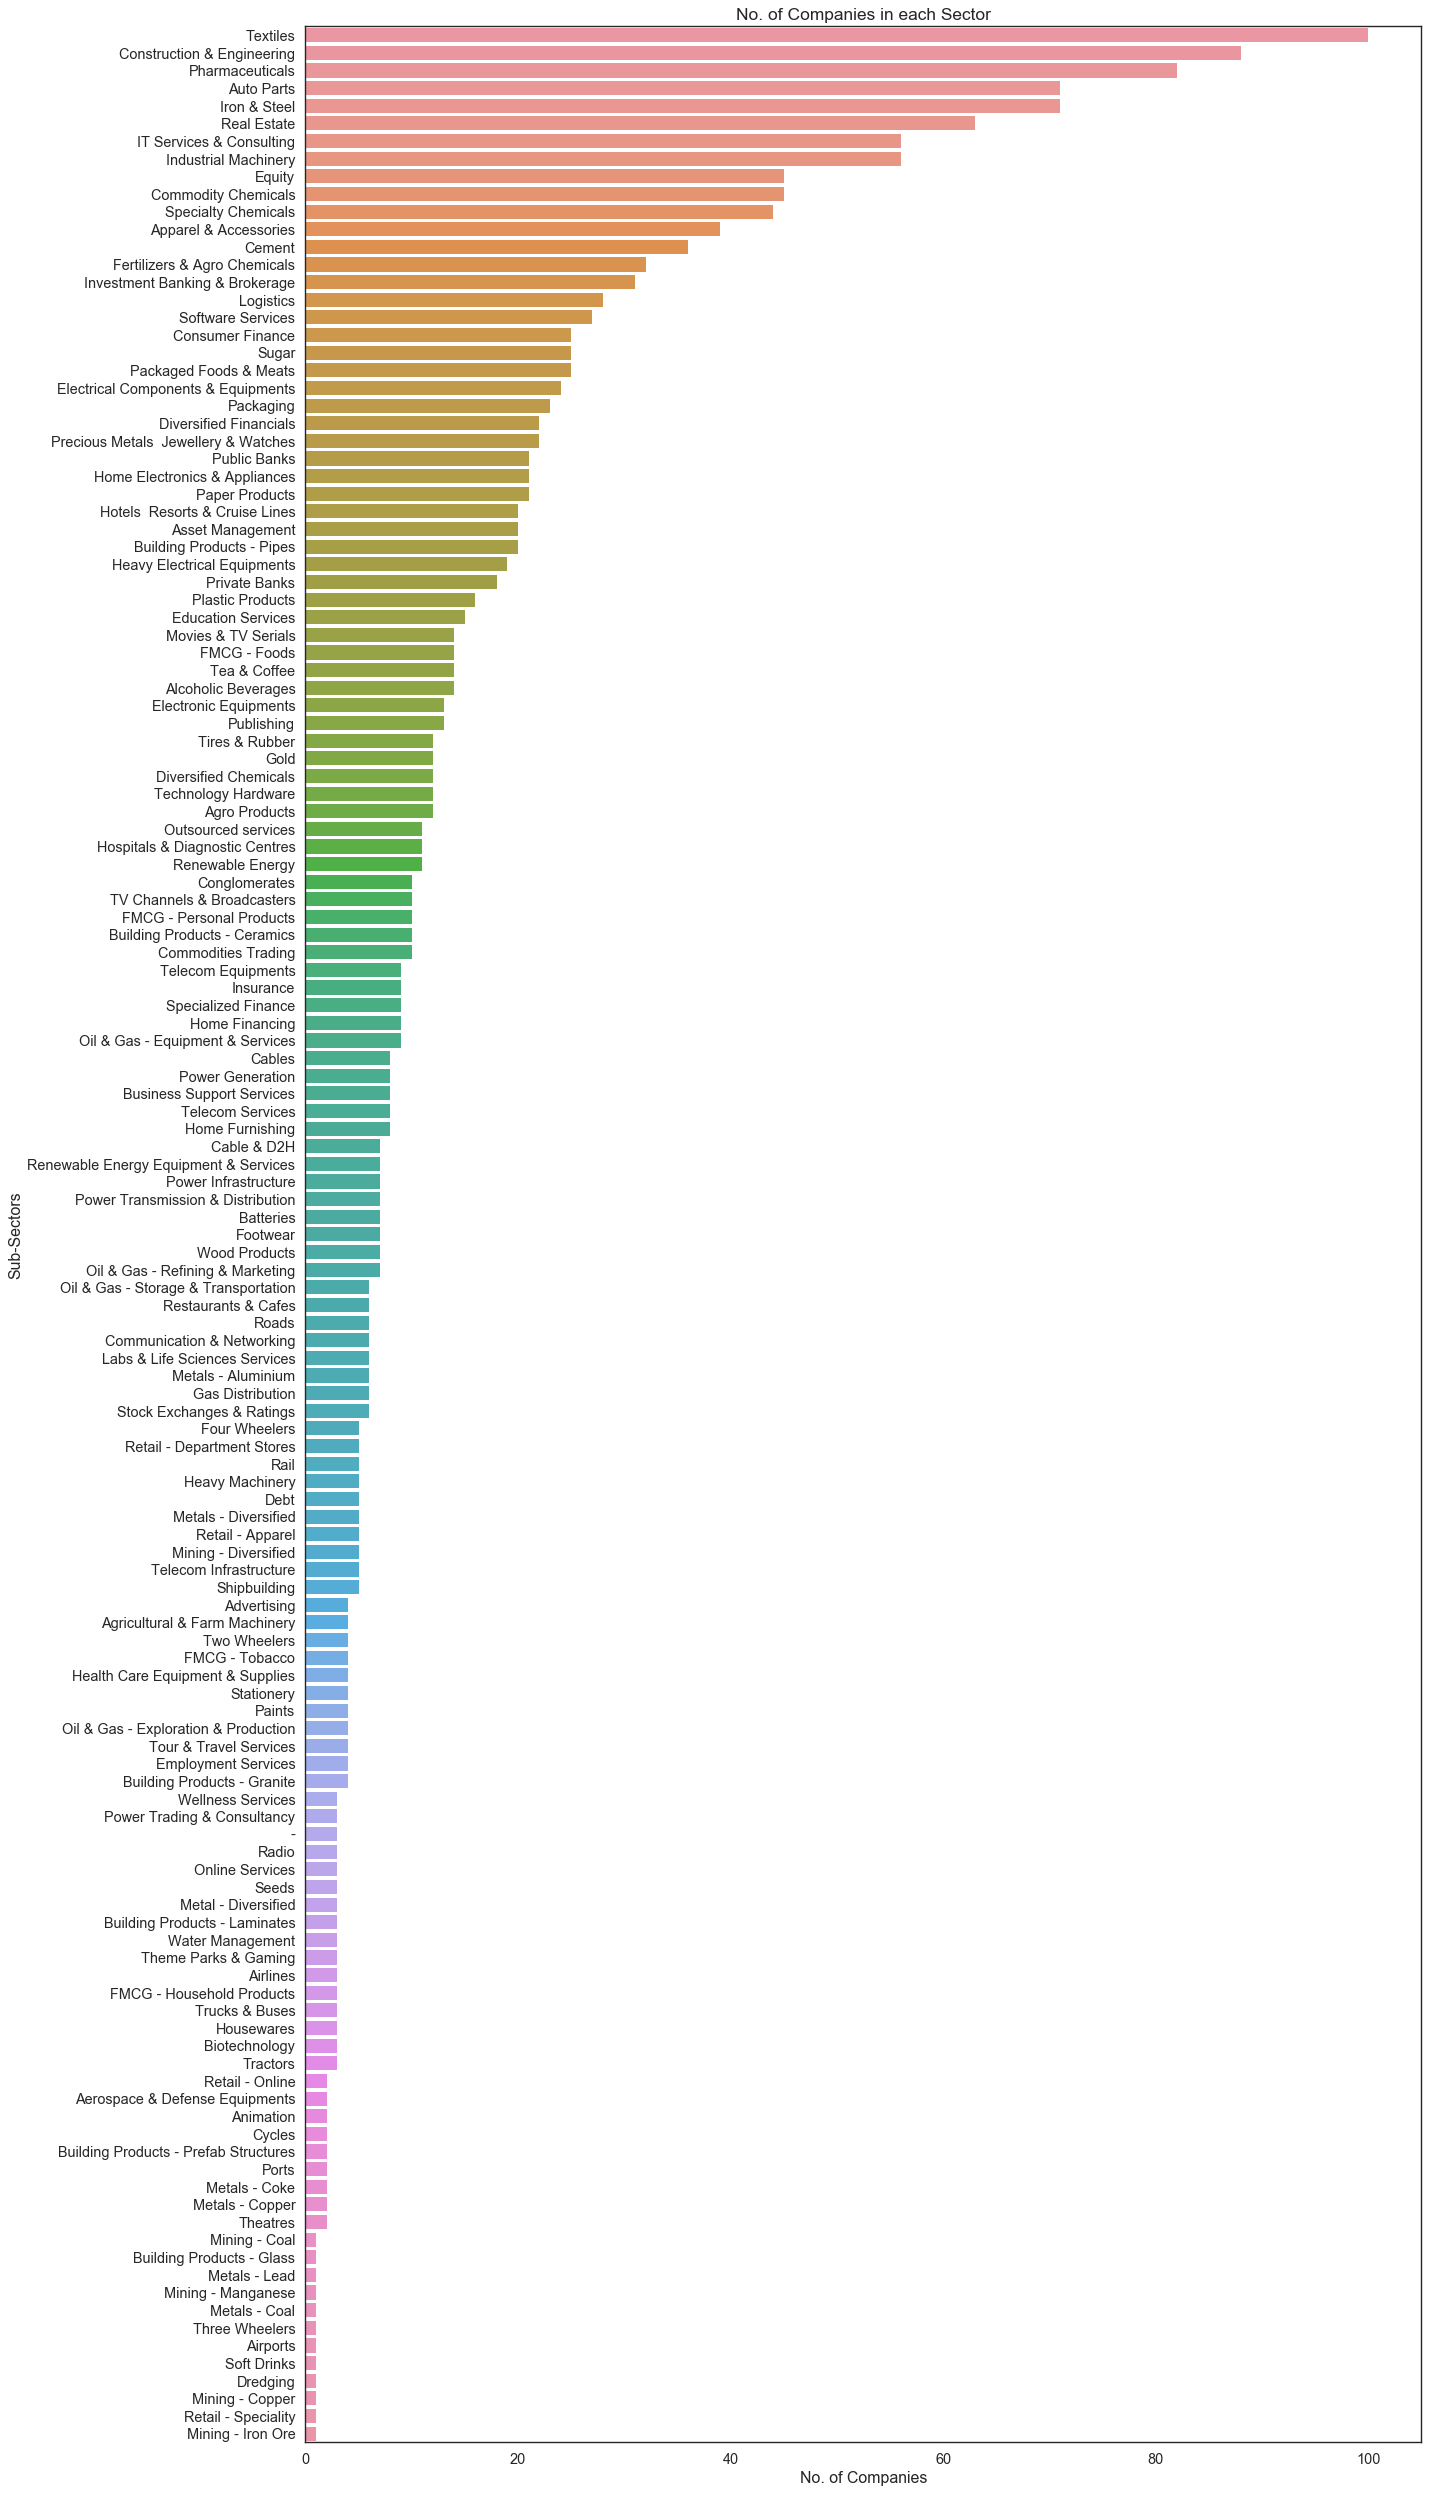

In [34]:
fig=plt.figure(figsize=(18, 40), dpi= 80, facecolor='w', edgecolor='k')
count_plot = sns.countplot(y = eq_fin_data_copy['Sub-Sector'],order=eq_fin_data_copy['Sub-Sector'].value_counts().index)
count_plot.set_ylabel('Sub-Sectors')
count_plot.set_title('No. of Companies in each Sector')
plt.xlabel('No. of Companies')
#eq_fin_data_copy['Sub-Sector'].value_counts(sort= True ).plot.barh()

### Few of the sectors above might not serve our purpose at all

In [35]:
may_be_unwanted_sectors = ['Conglomerates', 'Asset Management', '-', 'Equity']

#### Lets go through the companies of each may_be_unwanted_sector

Conglomerates Sector is a sector of companies where the income of companies are generated from more than one source. In dropping the sector we will lose a couple of stocks which are part of FnO segment too.

In [40]:
stocks_in_conglomerates = eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == 'Conglomerates'].index
print 'These many stocks belong to Conglomerates Sector : {}'.format(list(stocks_in_conglomerates))
print '\n'
print 'Stocks in Conglomerate which are part of FnO Segment: {}'.format(
    [i for i in stocks_in_conglomerates if i in f_n_o_list])
print '\n'
eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == 'Conglomerates'].head()

These many stocks belong to Conglomerates Sector : ['SIEMENS', 'JPASSOCIAT', 'BALMLAWRIE', 'NBVENTURES', 'FELDVR', 'FEL', 'ZUARIGLOB', 'DCM', 'HIGHGROUND', 'GILLANDERS']


Stocks in Conglomerate which are part of FnO Segment: ['SIEMENS', 'JPASSOCIAT']




,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
Ticker,,,,,,,,,,,,,,,
SIEMENS,Conglomerates,35647.085938,31.711529,-25.965477,15.68479,9.96808,15.14590,NaN,1.300000,7.300000,0.691563,1583.598999,4069.399902,NaN,1.61837
JPASSOCIAT,Conglomerates,3626.998047,-1.884039,-34.924080,-45.64233,-33.45586,-7.69439,549.419128,-45.599998,60.299999,NaN,1148.920044,1536.260010,32005.279297,2.31354
BALMLAWRIE,Conglomerates,2513.753906,15.480637,-8.762992,11.70612,9.37678,10.92717,0.765990,-3.900000,6.500000,4.467277,218.789993,778.020020,170.919998,0.76491
NBVENTURES,Conglomerates,2366.854004,9.339348,0.903274,7.27115,11.83996,4.03622,98.204407,69.300003,468.899994,1.118985,804.130615,461.300690,4007.601562,1.28379
FELDVR,Conglomerates,1855.786011,NaN,17.656250,NaN,NaN,NaN,NaN,13.800000,-90.400002,NaN,NaN,NaN,NaN,NaN


Equity seems to be a sector of ETFs

In [41]:
stocks_in_equity = eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == 'Equity'].index
print 'These many stocks belong to Equity Sector : {}'.format(list(stocks_in_equity))
print '\n'
print 'Stocks in Equity which are part of FnO Segment: {}'.format([i for i in stocks_in_equity if i in f_n_o_list])
eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == 'Equity'].head()

These many stocks belong to Equity Sector : ['ICICIB22', 'CPSEETF', 'ICICINIFTY', 'NIFTYBEES', 'BANKBEES', 'N100', 'SETFNN50', 'JUNIORBEES', 'SETFNIFBK', 'KOTAKNIFTY', 'M100', 'UTINEXT50', 'M50', 'ICICINF100', 'RELNV20', 'PSUBNKBEES', 'AXISNIFTY', 'RELDIVOPP', 'BSLNIFTY', 'RELCNX100', 'HNGSNGBEES', 'KOTAKBKETF', 'ICICILOVOL', 'IVZINNIFTY', 'ICICINV20', 'QNIFTY', 'INFRABEES', 'EQ30', 'SHARIABEES', 'EBANK', 'ICICIMCAP', 'HDFCNIFETF', 'KOTAKPSUBK', 'LICNFNHGP', 'ICICISENSX', 'HDFCSENETF', 'NIFTYEES', 'LICNETFSEN', 'LICNETFN50', 'IDFNIFTYET', 'KOTAKNV20', 'SETFNIF50', 'UTISENSETF', 'UTINIFTETF', 'ICICI500']


Stocks in Equity which are part of FnO Segment: []


,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
Ticker,,,,,,,,,,,,,,,
ICICIB22,Equity,14505.953125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPSEETF,Equity,10868.165039,NaN,2.642352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ICICINIFTY,Equity,1287.677002,NaN,15.850172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIFTYBEES,Equity,1187.057007,NaN,16.897106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BANKBEES,Equity,464.674011,NaN,14.503292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


('-') Litlle weird name for a sector. Lets see its content and anything common in with our FnO list

In [42]:
stocks_in_NA = eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == '-'].index
print 'These many stocks : {}'.format(list(stocks_in_NA))
print '\n'
print 'Stocks part of FnO Segment: {}'.format([i for i in stocks_in_NA if i in f_n_o_list])
eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == '-']

These many stocks : ['PITTIENG', 'AVONMPL', 'SUBCAPCITY']


Stocks part of FnO Segment: []


,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
Ticker,,,,,,,,,,,,,,,
PITTIENG,-,248.466003,22.027887,54.545456,8.44965,2.91043,5.20974,57.375519,26.799999,136.699997,NaN,54.5826,14.3279,260.253387,1.04245
AVONMPL,-,16.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUBCAPCITY,-,3.634000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Last!. Lets check Asset Management Sector

In [43]:
stocks_in_asset_management = eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == 'Asset Management'].index
print 'These many stocks : {}'.format(list(stocks_in_asset_management))
print '\n'
print 'Stocks part of FnO Segment: {}'.format([i for i in stocks_in_asset_management if i in f_n_o_list])
eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == 'Asset Management'].head()

These many stocks : ['BAJAJHLDNG', 'RNAM', 'TATAINVEST', 'JSWHL', 'PILANIINVS', 'KICL', 'BFINVEST', 'SUMMITSEC', 'NSIL', 'IVC', 'CREST', 'DHUNINV', 'NAHARCAP', 'CONSOFINVT', 'IITL', 'STEL', 'JPOLYINVST', 'MCDHOLDING', 'NAGREEKCAP', 'BALAXI']


Stocks part of FnO Segment: []


,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
Ticker,,,,,,,,,,,,,,,
BAJAJHLDNG,Asset Management,32921.960938,12.495598,32.418022,13.541580,632.610474,13.51797,NaN,-50.200001,2.100000,1.342192,-64.599998,894.789978,NaN,0.57256
RNAM,Asset Management,15623.851562,30.767469,NaN,25.096149,32.912991,24.91647,NaN,21.299999,32.700001,2.233805,-1055.000000,691.000000,NaN,NaN
TATAINVEST,Asset Management,4448.916992,18.112827,2.570399,9.513820,76.252129,9.15181,NaN,15.200000,19.500000,2.227998,283.595215,14.610300,NaN,0.77570
JSWHL,Asset Management,2178.532959,33.066586,16.977894,7.689400,76.832893,7.62302,NaN,39.900002,42.400002,NaN,83.560799,7.982400,NaN,0.96121
PILANIINVS,Asset Management,1891.594971,13.666667,3.977876,10.021870,79.092659,2.34289,NaN,16.299999,224.399994,1.063875,-7.893200,151.404205,NaN,NaN


Dropping Asset Management sector doesnt seem to be a good idea as their are quite a big names in that sector also with larger market capitalizations. Though there are quiet a few NA values in each row so we might look company wise dropping rather than dropping the sector itself

In [44]:
# lets drops the unwanted sectors
eq_fin_data_copy = eq_fin_data_copy[(eq_fin_data_copy['Sub-Sector'] != 'Conglomerates') & (eq_fin_data_copy['Sub-Sector'] != '-') &
                    (eq_fin_data_copy['Sub-Sector'] != 'Equity')]

In [45]:
eq_fin_data_copy.shape # Successfully dropped 58 companies

(1799, 15)

### Lets look at sector-wise market capitalization and see the sectors where the contribution is insignificant. May be we can drop somemore companies

In [46]:
sector_wise_mar_cap = pd.DataFrame(eq_fin_data_copy.groupby(by='Sub-Sector')['Market Cap'].sum().sort_values(
    ascending = False))

sector_wise_mar_cap['%MarketCap'] = (sector_wise_mar_cap / sector_wise_mar_cap.sum()) * 100

sector_wise_mar_cap.drop('Market Cap', inplace =True, axis = 1)

In [47]:
sector_wise_mar_cap.head()

,%MarketCap
Sub-Sector,
Private Banks,10.007181
IT Services & Consulting,9.838375
Oil & Gas - Refining & Marketing,6.946739
Pharmaceuticals,4.422003
Four Wheelers,3.616494


In [48]:
sector_wise_mar_cap.tail()

,%MarketCap
Sub-Sector,
Debt,0.003149
Advertising,0.002909
Retail - Speciality,0.000704
Metals - Copper,0.000632
Building Products - Glass,0.000063


Text(0,0.5,'%MarketCap')

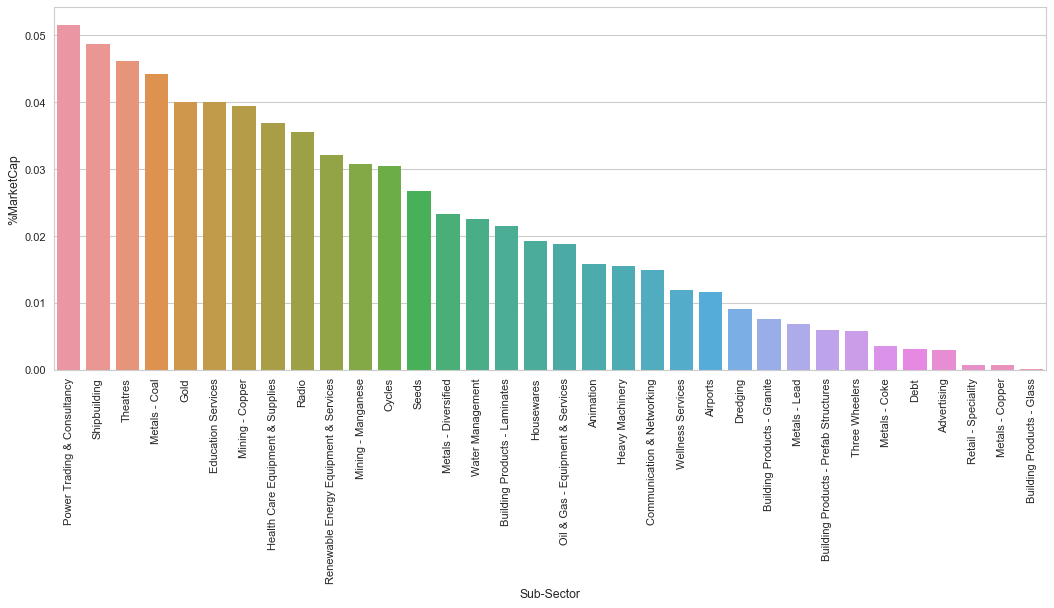

In [51]:
# This is the chart of the bottom sectors' market capitalization
fig=plt.figure(figsize=(16,6), dpi= 80, facecolor='w', edgecolor='k')
sns.set(style="whitegrid")
sns.barplot( x = sector_wise_mar_cap.index[100:], y = sector_wise_mar_cap['%MarketCap'][100:] )
plt.xticks(rotation = 90)
plt.ylabel('%MarketCap')

### Lets calculate the number of sectors and the total number of companies that fall in the bottom 10% of the total Market Cap.
If the Number is insigficant we can drop these sectors. 
But we need to do some checks as to whether any of these companies are also in for FnO segment before dropping

In [52]:
sector_wise_mar_cap['%CumulativeMarCap'] = sector_wise_mar_cap.cumsum()
sector_with_low_mar_cap = sector_wise_mar_cap[sector_wise_mar_cap['%CumulativeMarCap']>90]

In [53]:
sector_with_low_mar_cap.tail()

,%MarketCap,%CumulativeMarCap
Sub-Sector,,
Debt,0.003149,99.995712
Advertising,0.002909,99.998619
Retail - Speciality,0.000704,99.999321
Metals - Copper,0.000632,99.999954
Building Products - Glass,0.000063,100.000015


In [54]:
# Lets see how many sectors falls in last 10% of market cap
len(sector_with_low_mar_cap)

85

In [55]:
sector_with_low_mar_cap.head()

,%MarketCap,%CumulativeMarCap
Sub-Sector,,
Specialized Finance,0.421329,90.178162
Asset Management,0.409011,90.587173
Metals - Aluminium,0.392632,90.979805
Packaged Foods & Meats,0.387137,91.366943
Telecom Infrastructure,0.366934,91.733879


In [56]:
# Now Lets check the number of companies that only contribute to a total of 10% market cap
companies_with_low_market_cap = eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'].isin(sector_with_low_mar_cap.index)].index

In [57]:
# There are quite a few big names
print companies_with_low_market_cap

Index([u'INFRATEL', u'HINDALCO', u'INDIGO', u'PETRONET', u'BIOCON', u'NMDC',
       u'BAJAJHLDNG', u'HAL', u'DIVISLAB', u'BEL',
       ...
       u'AHIMSA', u'XLENERGY', u'TULSI', u'PRAKASHSTL', u'JIKIND', u'UMESLTD',
       u'TODAYS', u'ABNINT', u'GOKULAGRO', u'DSML'],
      dtype='object', name=u'Ticker', length=589)


#### Sanity Check 

In [44]:
print [script for script in f_n_o_list if script in companies_with_low_market_cap]

[u'ADANIENT', u'AMARAJABAT', u'APOLLOHOSP', u'BALRAMCHIN', u'BATAINDIA', u'BEL', u'BEML', u'BIOCON', u'DISHTV', u'DIVISLAB', u'ESCORTS', u'EXIDEIND', u'HINDALCO', u'IFCI', u'INDIGO', u'INFIBEAM', u'INFRATEL', u'JETAIRWAYS', u'JISLJALEQS', u'JUBLFOOD', u'JUSTDIAL', u'KAJARIACER', u'KSCL', u'MCX', u'NATIONALUM', u'NHPC', u'NMDC', u'PETRONET', u'PFC', u'PTC', u'PVR', u'RECLTD', u'RELINFRA', u'SREINFRA', u'SUZLON', u'TATAGLOBAL']


A lot of companies that belong in the lower 10% of sectors in terms of Market Cap are also in FnO segment. So lets drop the idea of eliminating sectors and move into analysis of Missing Values and figure out ways to impute them

In [58]:
eq_fin_data_copy.shape

(1799, 15)

### Imputation of Missing Values
Generally we impute Missing Values or 'NaN' values before proceeding to Machine Learning

Common ways of Imputation-
1. Mean , Mode, median
2. Nearest Neighbours
3. Drop Rows or Columns

First method does not make sense as all the companies have their independent attributes. 

Second method does work. What we can do is we can group companies on their sectors and try to impute missing values using nearest neighbours. This may come handy, but lets put it aside as of now. Again the decision is arbitrary. You may choose to do it.

There is one another Brute Force way of imputing and that is finding real values by going through company websites, annual reports, etc.

Lets go through the data and do some Exploratory Data Analysis and then choose method that perfectly suits the situation

In [45]:
# Null Values Columnwise
eq_fin_data_copy.isnull().sum()

Sub-Sector                        0
Market Cap                        6
PE Ratio                        103
1Y Return                       332
Return on Equity                252
Net Profit Margin               120
Return on Investment            222
Long Term Debt to Equity        552
1Y Historical Revenue Growth    188
1Y Historical EPS Growth        129
Dividend Yield                  924
EBITDA                          106
Cash and Equivalent             105
Total Debt                      200
Beta                            425
dtype: int64

There are 14 Attributes where we have null values. 

### Missing Data visualization

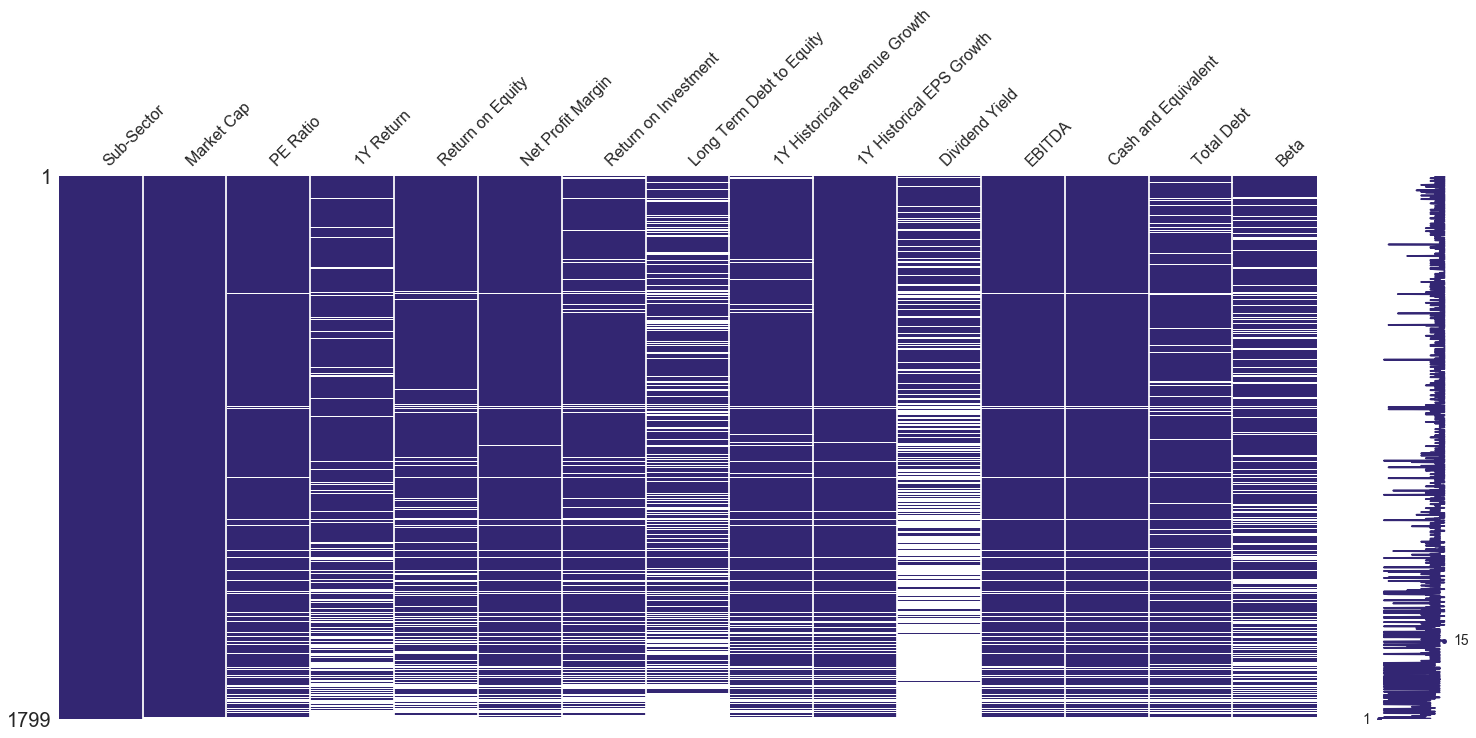

In [46]:
msno.matrix(eq_fin_data_copy,color=(0.20,0.15,0.45))

Remember! We have sorted rows on the basis of Market Capitalization in descending order. Most of the missing values are in the bottom rows very Market Cap values should be low

In [59]:
# Dropping rows where Market Cap columns have NA values
eq_fin_data_copy.dropna(axis = 0,subset= ['Market Cap'], inplace = True)
print eq_fin_data_copy.isnull().sum()

eq_fin_data_copy.shape

Sub-Sector                        0
Market Cap                        0
PE Ratio                         99
1Y Return                       328
Return on Equity                248
Net Profit Margin               116
Return on Investment            218
Long Term Debt to Equity        548
1Y Historical Revenue Growth    184
1Y Historical EPS Growth        125
Dividend Yield                  918
EBITDA                          102
Cash and Equivalent             101
Total Debt                      196
Beta                            419
dtype: int64


(1793, 15)

In [48]:
eq_fin_data_copy.tail()

,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
Ticker,,,,,,,,,,,,,,,
SGFL,Iron & Steel,1.688,-0.302691,NaN,NaN,-63384.089844,-18.315769,NaN,-98.199997,20.5,NaN,-1.0985,2.008761,139.903366,1.08048
RAMSARUP,Iron & Steel,1.578,-0.028362,NaN,NaN,-2232.633057,NaN,NaN,9.600000,-31.5,NaN,-8.8326,1.583600,2047.956299,-0.24561
BILPOWER,Iron & Steel,1.575,0.186725,NaN,NaN,37.255081,NaN,NaN,62.500000,-110.0,NaN,4.5874,0.511900,180.055603,-0.39343
GRETEX,Apparel & Accessories,1.247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOESISIND,Home Electronics & Appliances,0.132,-0.192308,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,-0.2114,0.556700,245.769501,-0.05838



### Visualization of Missing Data for FnO companies

In [61]:
f_n_o_eq_fin_data = []
for item in f_n_o_list:
    if item in eq_fin_data_copy.index:
        f_n_o_eq_fin_data.append(eq_fin_data_copy.loc[item,:])

f_n_o_eq_fin_data = pd.DataFrame(f_n_o_eq_fin_data)


In [62]:
f_n_o_eq_fin_data.shape

(204, 15)

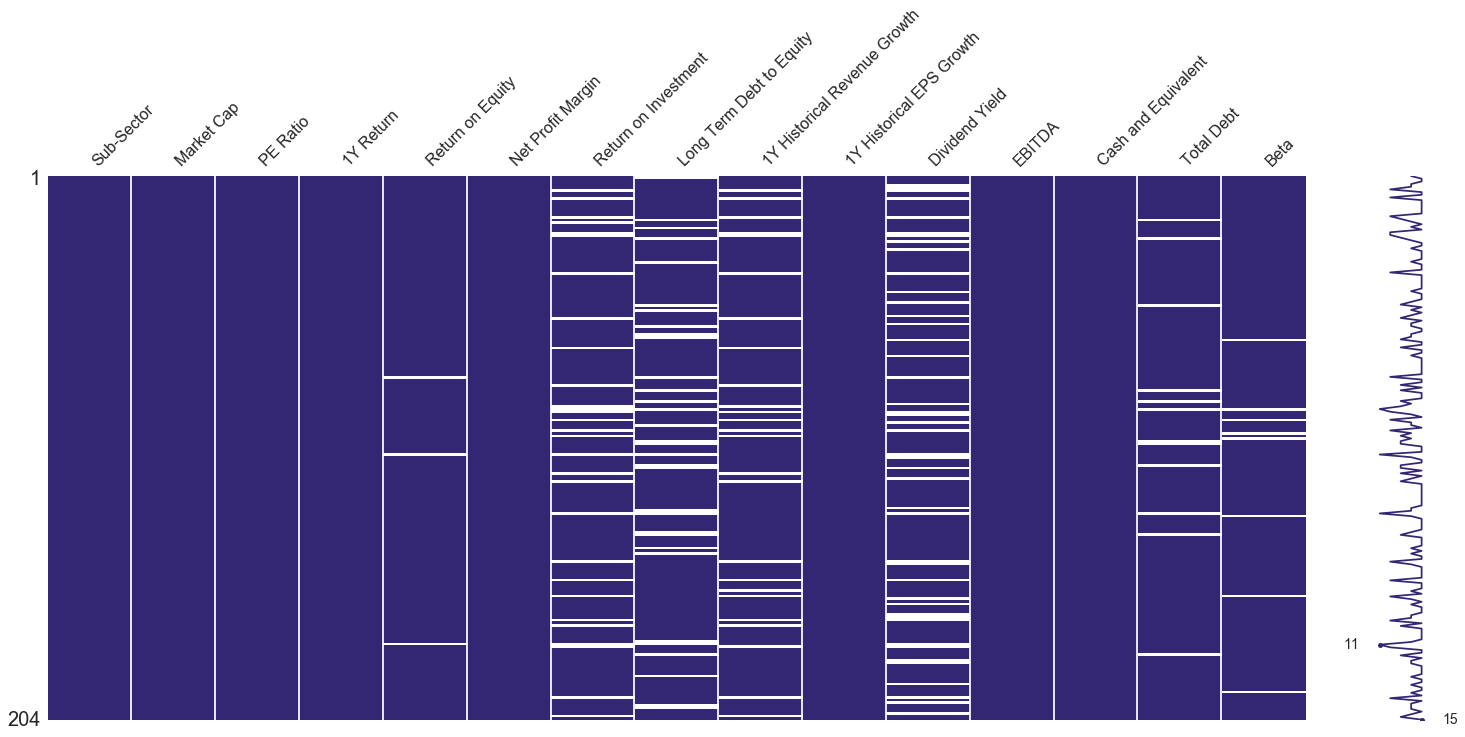

In [63]:
msno.matrix(f_n_o_eq_fin_data,color=(0.20,0.15,0.45))

Most of the concentration of missing values is in Dividend Yield, ROI, Long Term Debt2Equity & 1Yr Historical Revenue Growth

In [64]:
# Now lets Figure out the number of Null values that is contained in the each of FnO list companies and 
# sort in descending order. Simply finding null values rowwise and not columnwise
eq_fin_data_copy[eq_fin_data_copy.index.isin(f_n_o_list)].isnull().sum(axis = 1).sort_values(ascending = False).head()

Ticker
SUZLON        4
MFSL          4
ICICIPRULI    4
JETAIRWAYS    4
IDBI          3
dtype: int64

Highest Null value for any FnO company is not more than 4. So Lets first drop companies where the Null values are 5 or more than 5

In [65]:
na_values_more_than_5 = eq_fin_data_copy[eq_fin_data_copy.isnull().sum(axis = 1) >= 5].index 
len(na_values_more_than_5)

164

A total of 164 companies have missing values of 5 more than 5.

#### Sanity Check before dropping

In [66]:
print [scrip for scrip in na_values_more_than_5 if scrip in f_n_o_list]

[]


In [67]:
# Dropping companies where NA values is either 5 or more than 5
eq_fin_data_copy.dropna(axis = 0 , thresh= 11, inplace= True)

In [68]:
eq_fin_data_copy.shape

(1629, 15)

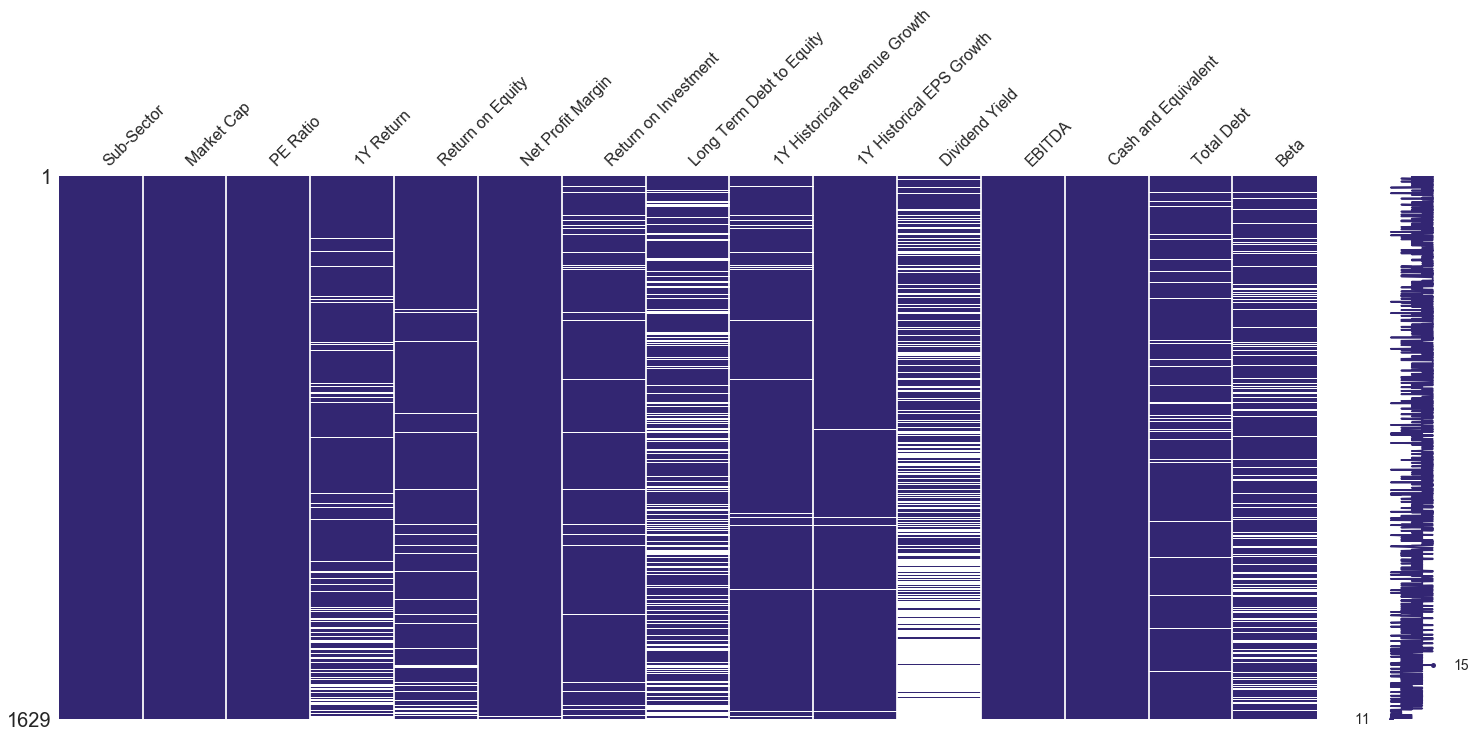

In [69]:
# Lets visualize missing values again for the whole data
msno.matrix(eq_fin_data_copy,color=(0.20,0.15,0.45))

One thing to notice is that the concentration of the NA values is mostly in the lower end of the Dataframe. May be chopping off some companies on the basis of some arbitrary market cap threshold will help.

But before we drop companies on basis of some arbitrary threshold, lets find the company in FnO list who has lowest market Cap. This can help decide the threshold and we also not accidentally drop any FnO list company

In [70]:
f_n_o_eq_fin_data.sort_values(by='Market Cap',ascending = False).tail()

,Sub-Sector,Market Cap,PE Ratio,1Y Return,Return on Equity,Net Profit Margin,Return on Investment,Long Term Debt to Equity,1Y Historical Revenue Growth,1Y Historical EPS Growth,Dividend Yield,EBITDA,Cash and Equivalent,Total Debt,Beta
SREINFRA,Specialized Finance,2753.053955,7.555123,-56.216831,7.54977,7.62845,2.56513,196.076904,12.700000,70.599998,0.865801,1205.900024,2852.449951,32873.230469,0.91547
GRANULES,Pharmaceuticals,2699.313965,19.287020,-27.466484,12.01132,6.89205,8.06690,33.211029,17.900000,-26.600000,0.947867,278.420685,117.066803,1008.230286,1.13986
PTC,Power Trading & Consultancy,2449.102051,6.901486,-29.847588,9.10274,2.05680,3.60730,194.633408,28.299999,-14.300000,4.828002,1519.589966,1463.239990,11348.019531,1.48535
BALRAMCHIN,Sugar,1672.137939,7.276876,-54.386524,14.58116,5.26437,12.61175,0.659840,20.900000,-60.900002,3.484321,451.660004,60.580002,1045.699951,1.31792
HCC,Construction & Engineering,1172.567017,-1.457312,-70.931679,NaN,-10.75751,-22.67123,NaN,2.700000,21.600000,NaN,624.250000,429.369995,9455.570312,2.58885


Great! HCC seems to be the lowest in Market Cap but that too is significant amount of 1200 Crores.

Lets see how many companies fall below the 200 Crore Market Cap bracket.

In [71]:
cos_less_than_200 = eq_fin_data_copy[eq_fin_data_copy['Market Cap'] < 200]

In [72]:
cos_less_than_200.shape

(496, 15)

In [73]:
cos_less_than_200.isnull().sum(axis=0) #Finding the missing values concentration for companies which have marketcap < 200Cr

Sub-Sector                        0
Market Cap                        0
PE Ratio                          0
1Y Return                       133
Return on Equity                 79
Net Profit Margin                 4
Return on Investment             22
Long Term Debt to Equity        160
1Y Historical Revenue Growth     12
1Y Historical EPS Growth          7
Dividend Yield                  416
EBITDA                            2
Cash and Equivalent               2
Total Debt                       13
Beta                            112
dtype: int64

In [74]:
 eq_fin_data_copy.isnull().sum() #  And this is overall

Sub-Sector                        0
Market Cap                        0
PE Ratio                          0
1Y Return                       194
Return on Equity                111
Net Profit Margin                 5
Return on Investment             80
Long Term Debt to Equity        402
1Y Historical Revenue Growth     60
1Y Historical EPS Growth         12
Dividend Yield                  759
EBITDA                            2
Cash and Equivalent               2
Total Debt                       84
Beta                            294
dtype: int64

The idea is to eliminate as many NA values as possible. Below cell calculates the % of NA values we will be able to eliminate by dropping companies that are below 200 Crore of Market Cap

In [75]:
(cos_less_than_200.isnull().sum(axis = 0)/ eq_fin_data_copy.isnull().sum()) * 100

Sub-Sector                             NaN
Market Cap                             NaN
PE Ratio                               NaN
1Y Return                        68.556701
Return on Equity                 71.171171
Net Profit Margin                80.000000
Return on Investment             27.500000
Long Term Debt to Equity         39.800995
1Y Historical Revenue Growth     20.000000
1Y Historical EPS Growth         58.333333
Dividend Yield                   54.808959
EBITDA                          100.000000
Cash and Equivalent             100.000000
Total Debt                       15.476190
Beta                             38.095238
dtype: float64

In [76]:
eq_fin_data_copy.drop(cos_less_than_200.index, inplace = True) #  Dropping all companies below 200 market cap

In [77]:
eq_fin_data_copy.shape

(1133, 15)

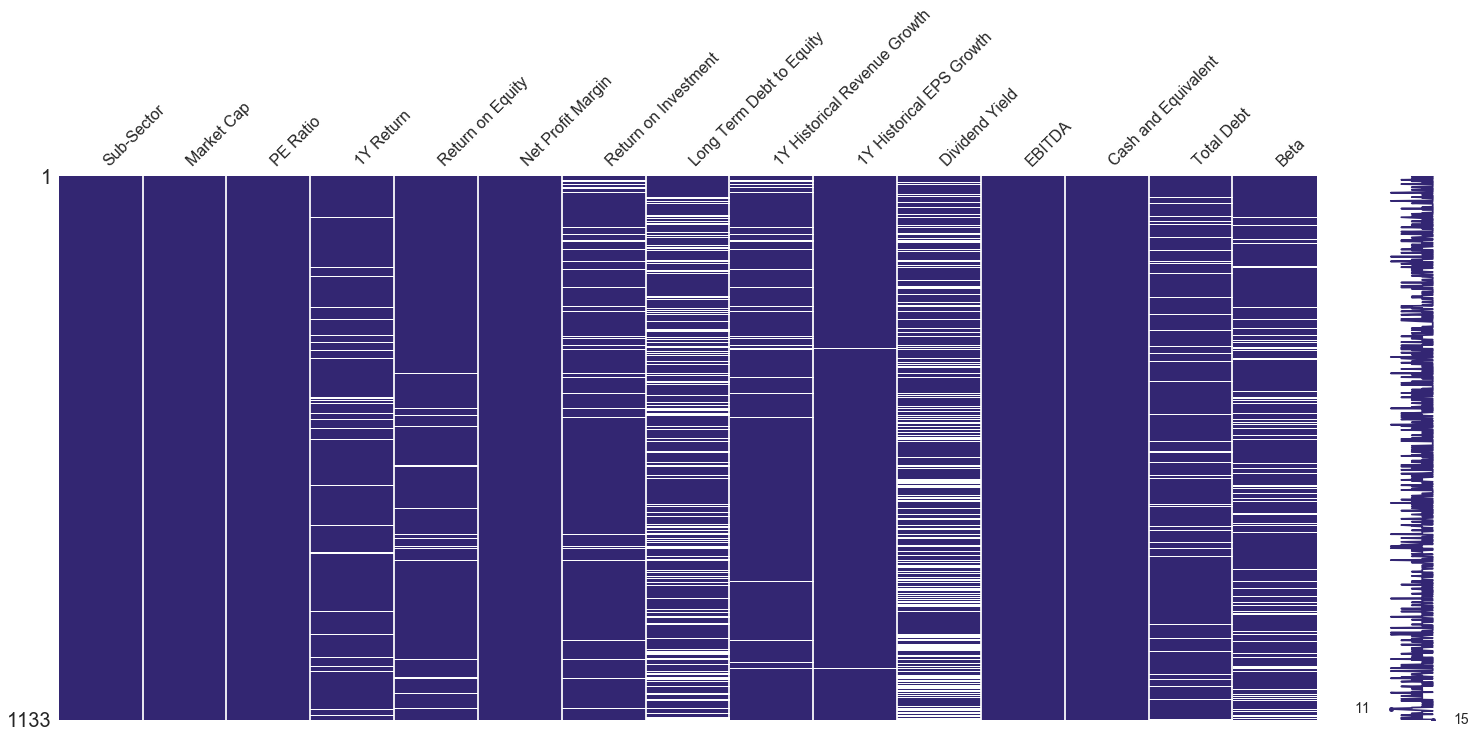

In [79]:
# Lets check again for the dataset
msno.matrix(eq_fin_data_copy , color=(0.20,0.15,0.45))

In order to Impute NA values, dropping items generally is not a good idea unless it is unavoidable. In our case, considering the goal of finding best cointegrated pairs to trade where we take a long position in one leg of the pair and shorting other leg we should be fine.

There are a few columns which also seems to be redundant keeping in mind that we will also be using Historical Pricing Data.
1. 1Y Return seems a bit off as we can calculate this using Historical Price Data too
2. Long Term Debt to Equity can be eliminated as we are using Total Debt column as well
3. Dividend Yield though important, seeing the amount of NA values can be dropped as well
4. Finally Beta column. Well Beta can be really vital because we want our Clustering Algorithm to cluster stocks also on the basis of the systematic risk of individual stocks but this we can mitigate by using PCA components which represents the directions of maximum variance in the data. More on [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

After this we can do a Central Imputation using Median or Mean values after grouping the stocks on the sector column. This forces the algorithm to cluster stocks that atleast belong to same Sectors and this does make some intuitive sense. Offcourse we would want this to happen afterall the companies that belong to same sector would more or less have same attributes like- business models, P/E, same market to operate in, etc.

But this can still be taken care by choosing the optimal Hyperparameter of Kmeans Algorithm and that is K (No. of Clusters).
We can do this by using Elbow method.

### Lets begin!

In [80]:
# Dropping Columns
columns_to_drop = [ '1Y Return','Long Term Debt to Equity', 'Dividend Yield', 'Beta' ]
eq_fin_data_copy.drop(columns_to_drop, axis = 1, inplace = True)

In [81]:
eq_fin_data_copy.shape

(1133, 11)

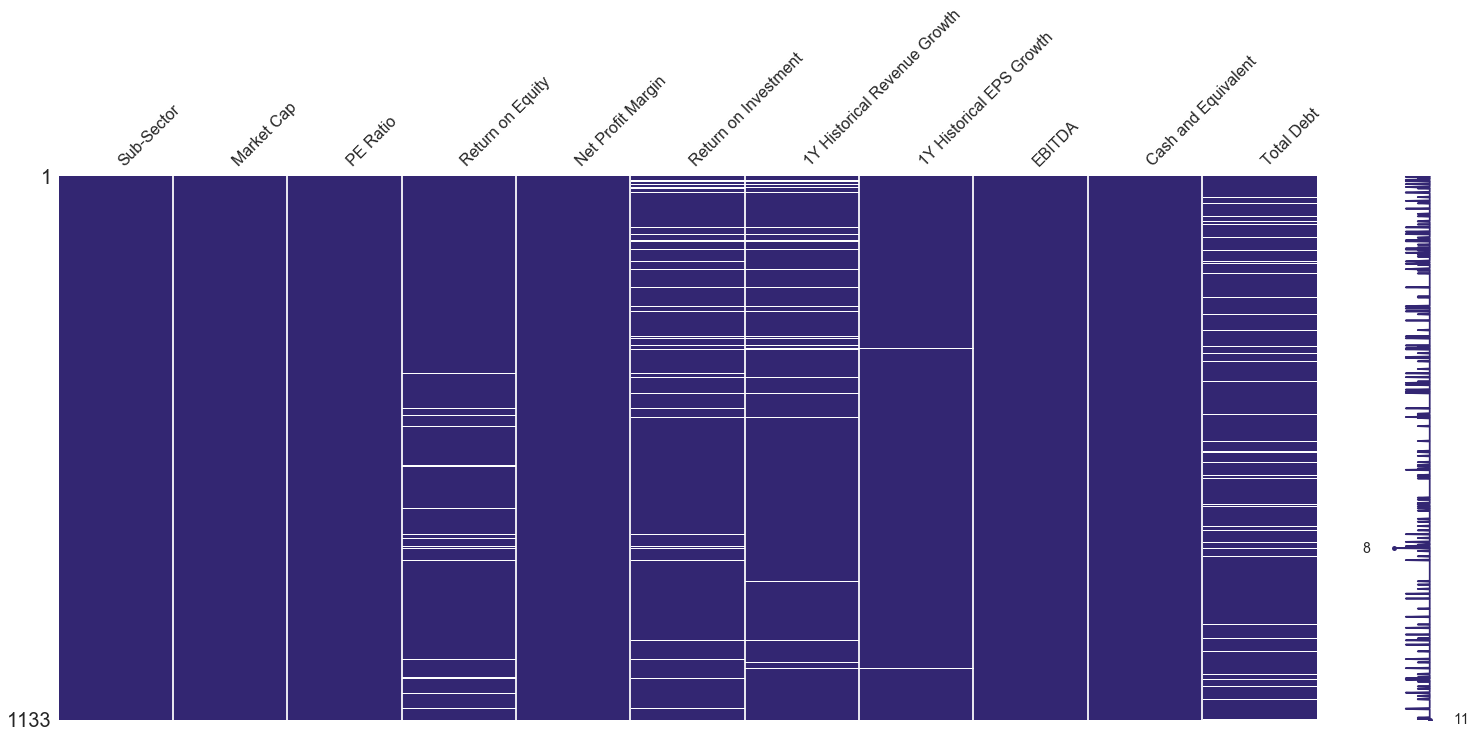

In [82]:
msno.matrix(eq_fin_data_copy, color=(0.20,0.15,0.45))

#### Imputation. Remember we want to impute missing values by grouping companies on their sector and than impute on Mean.

In [83]:
eq_fin_data_copy['Sub-Sector'].nunique()

128

#### Converting strings to Integers
Below cell helps us converts sector strings to integers. These numbers though arbitrarily chosen but are in sequence. 
    

In [86]:
eq_fin_data_copy['Sub-Sector'] = pd.factorize(eq_fin_data_copy['Sub-Sector'])[0] 

In [87]:
eq_fin_data_copy.head()

,Sub-Sector,Market Cap,PE Ratio,Return on Equity,Net Profit Margin,Return on Investment,1Y Historical Revenue Growth,1Y Historical EPS Growth,EBITDA,Cash and Equivalent,Total Debt
Ticker,,,,,,,,,,,
TCS,0,749015.87500,29.502325,30.145559,21.022869,29.335751,4.400000,0.500000,32532.000000,42681.000000,750.000000
RELIANCE,1,743480.18750,19.329933,12.948320,8.837400,7.415750,23.600000,24.200001,65488.000000,68264.000000,218766.000000
HDFCBANK,2,565373.06250,29.985825,18.381990,31.478809,NaN,NaN,19.799999,28463.921875,112314.476562,164663.875000
HINDUNILVR,3,389362.84375,73.230255,74.324417,14.418570,61.742981,1.300000,21.100000,7453.000000,7016.000000,132.000000
ITC,4,366742.25000,33.025909,22.787821,24.099449,22.265779,-18.799999,7.200000,16909.460938,13854.830078,36.220001


In [88]:
eq_fin_data_copy['Sub-Sector'].nunique()

128

In [89]:
# The command imputes the missing values using mean value on the basis of Sub-Sector groupings.
imputed_df = []
for value in eq_fin_data_copy['Sub-Sector'].unique():
    temp_df = eq_fin_data_copy[eq_fin_data_copy['Sub-Sector'] == value]
    temp_df = temp_df.apply(lambda x: x.fillna(x.mean()))
                                                                            
    imputed_df.append(temp_df)
    

In [91]:
eq_fin_data_copy_imputed = pd.concat(imputed_df, axis = 0)
eq_fin_data_copy_imputed = eq_fin_data_copy_imputed.sort_values(by = 'Market Cap', ascending= False)
eq_fin_data_copy_imputed.head()

,Sub-Sector,Market Cap,PE Ratio,Return on Equity,Net Profit Margin,Return on Investment,1Y Historical Revenue Growth,1Y Historical EPS Growth,EBITDA,Cash and Equivalent,Total Debt
Ticker,,,,,,,,,,,
TCS,0,749015.87500,29.502325,30.145559,21.022869,29.335751,4.400000,0.500000,32532.000000,42681.000000,750.000000
RELIANCE,1,743480.18750,19.329933,12.948320,8.837400,7.415750,23.600000,24.200001,65488.000000,68264.000000,218766.000000
HDFCBANK,2,565373.06250,29.985825,18.381990,31.478809,NaN,NaN,19.799999,28463.921875,112314.476562,164663.875000
HINDUNILVR,3,389362.84375,73.230255,74.324417,14.418570,61.742981,1.300000,21.100000,7453.000000,7016.000000,132.000000
ITC,4,366742.25000,33.025909,22.787821,24.099449,22.265779,-18.799999,7.200000,16909.460938,13854.830078,36.220001


In [92]:
# Lets check again if the work is done here!
eq_fin_data_copy_imputed.isnull().sum()

Sub-Sector                       0
Market Cap                       0
PE Ratio                         0
Return on Equity                 3
Net Profit Margin                0
Return on Investment            41
1Y Historical Revenue Growth    39
1Y Historical EPS Growth         0
EBITDA                           0
Cash and Equivalent              0
Total Debt                       1
dtype: int64

Oops! Not Yet!

Looks like there are still some missing values!
Lets fill it with 0


In [93]:
eq_fin_data_copy_imputed.fillna(0, inplace= True)

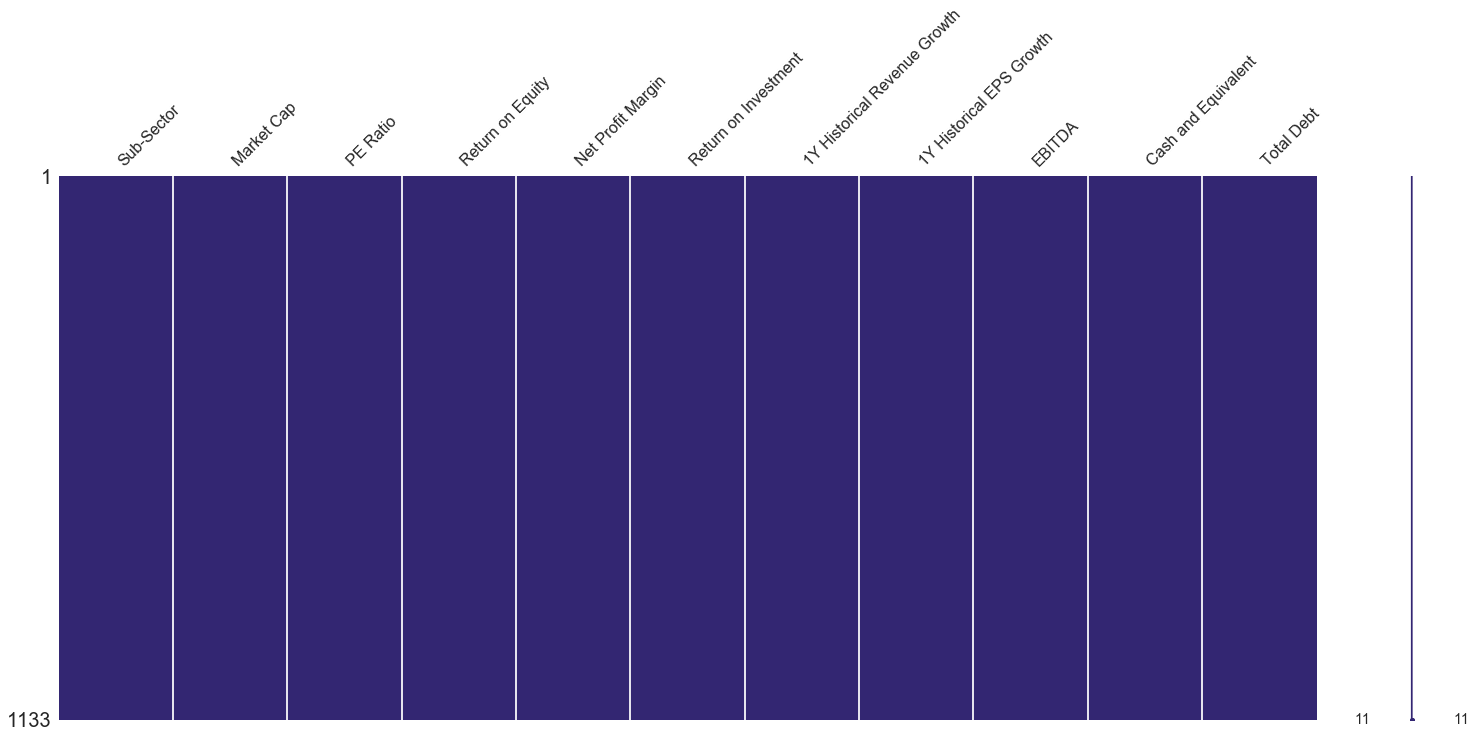

In [94]:
# Final Visit
msno.matrix(eq_fin_data_copy_imputed , color=(0.20,0.15,0.45))

### Finally!!!

#### Lastly lets see if the columns in our financial data shows any high correlation on the basis of company data given.
By the way the idea is to find correlation between companies on the basis of financial data

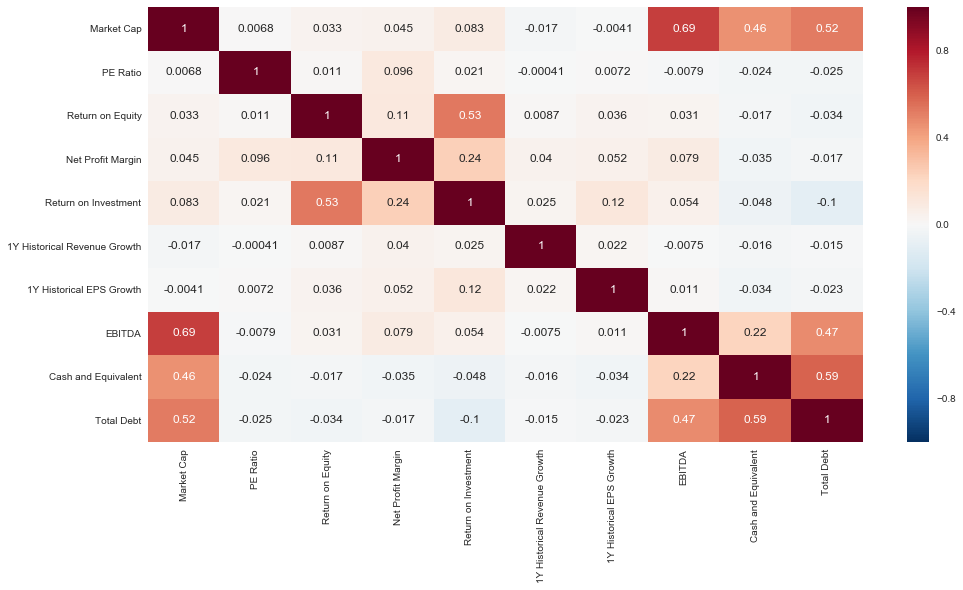

In [162]:
plt.figure(figsize=(16,8))
sns.heatmap(eq_fin_data_copy_imputed.iloc[:,1:].corr(), annot= True)

### Lets move ahead. Choosing Historical Past Prices

We will take past 2 years daily time frame data for this analysis. Choosing the granularity again is arbitrary and its upto you. One can go for weekly or even monthly closing prices as well. We will than use the same data for co-integration test

The Ticker column (Index in this case) in the eq_fin_data will come handy to call Yahoo API.

In [95]:
tickers = list(eq_fin_data_copy_imputed.index)
print 'Top 15 Stocks: {}'.format(tickers[0:15])
print '\n'
print 'Total Number of Stocks: {}'.format(len(tickers))

Top 15 Stocks: ['TCS', 'RELIANCE', 'HDFCBANK', 'HINDUNILVR', 'ITC', 'HDFC', 'INFY', 'MARUTI', 'SBIN', 'KOTAKBANK', 'ONGC', 'ICICIBANK', 'LT', 'COALINDIA', 'IOC']


Total Number of Stocks: 1133


Lets run 5 iterations to fetch data for 1133 companies from Yahoo. We may require more.
Sometimes Yahoo's Api returns empty dataframe, thats why we keep iterating.

In [102]:
pricing_data = {} # We will store dataframe of each stock in a dictionary
start='2016-04-01' # Start date
end='2018-03-31' # End Date

In [103]:
print '1st Iteration Started at {}'.format(datetime.now().strftime("%H:%M:%S"))
for stock in tickers:
    #if pricing_data[stock].empty:
    pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
    time.sleep(1)
    #elif stock not in pricing_data:
     #   pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
      #  time.sleep(1)
    #else:
     #   pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
      #  time.sleep(1)
print '\n'        
print '1st Iteration Ended at {}'.format(datetime.now().strftime("%H:%M:%S"))


print '2nd Iteration Started at {}'.format(datetime.now().strftime("%H:%M:%S"))
for stock in pricing_data:
    if pricing_data[stock].empty:
        pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
        time.sleep(1)
print '\n'
print '2nd Iteration Ended at {}'.format(datetime.now().strftime("%H:%M:%S"))        
 
    
    
print '3rd Iteration Started at {}'.format(datetime.now().strftime("%H:%M:%S"))
for stock in pricing_data:
    if pricing_data[stock].empty:
        pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
        time.sleep(1)
print '\n'
print '3rd Iteration Ended at {}'.format(datetime.now().strftime("%H:%M:%S"))
   
    
print '4th Iteration Started at {}'.format(datetime.now().strftime("%H:%M:%S"))
for stock in pricing_data:
    if pricing_data[stock].empty:
        pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
        time.sleep(1)
print '\n'
print '4th Iteration Ended at {}'.format(datetime.now().strftime("%H:%M:%S"))


print '5th Iteration Started at {}'.format(datetime.now().strftime("%H:%M:%S"))
for stock in pricing_data:
    if pricing_data[stock].empty:
        pricing_data[stock]=pdr.get_data_yahoo(stock+'.NS', start, end) # Looping through tickers to fetch and store data
        time.sleep(1)
print '\n'
print '5th Iteration Ended at {}'.format(datetime.now().strftime("%H:%M:%S"))

1st Iteration Started at 10:11:31
[*********************100%***********************]  1 of 1 downloaded

1st Iteration Ended at 11:01:10
2nd Iteration Started at 11:01:10
[*********************100%***********************]  1 of 1 downloaded

2nd Iteration Ended at 11:14:43
3rd Iteration Started at 11:14:43
[*********************100%***********************]  1 of 1 downloaded

3rd Iteration Ended at 11:18:49
4th Iteration Started at 11:18:49
[*********************100%***********************]  1 of 1 downloaded

4th Iteration Ended at 11:20:39
5th Iteration Started at 11:20:39
[*********************100%***********************]  1 of 1 downloaded

5th Iteration Ended at 11:22:27


pricing_data is a dictionary which contains Stock symbol as a key and its time series as a value

We will now run three different cells to figure out-
1. Whether we successfully received data for each stock
2. Whether we have received data from the start date we desired - '2016-04-01'
3. Wtether we have received data till the end date we desired - '2018-03-28' (Markets were closed for the rest of march,18)

In [107]:
# Stocks for which we found no data
no_data = []
for key in pricing_data:
    if pricing_data[key].empty:  # This checks whether the value of key is an empty dataframe
        no_data.append(key)

In [108]:
print 'Data not available for {} companies'.format(len(no_data))
print '\n'
print ' This is the list of companies for which data is not available:  {}'.format(no_data)
print '\n'
print '{} is the only stock which is also part of FnO list for which data was not available'.format([i for i in no_data if i in f_n_o_list])

Data not available for 32 companies


 This is the list of companies for which data is not available:  ['AIRAN', 'THEINVEST', 'SHRENIK', 'EIFFL', 'BOROSIL', 'ELECTROSL', 'ZOTA', 'SPTL', 'OLECTRA', 'ISEC', 'VARROC', 'MMP', 'LEMONTREE', 'HAL', 'MIDHANI', 'TCNSBRANDS', 'SIRCA', 'FINEORG', 'RITES', 'INDIGRID', 'ORIENTELEC', 'MCDOWELL-N', 'INDOSTAR', 'SANDHAR', 'CENTRUM', 'ADANIGREEN', 'GMMPFAUDLR', 'MAHESHWARI', 'KARDA', 'IRBINVIT', 'MACPOWER', 'RKEC']


['MCDOWELL-N'] is the only stock which is also part of FnO list for which data was not available


In [114]:
# Lets now check for stocks that doesnot have time series from our desired date- '2016-04-01'
stock_without_complete_data = []
error = [] # This will contain the 32 stocks name for which we didnt receive any data
for stock in pricing_data:
    try:
        if pricing_data[stock].index[0] != datetime.strptime('2016-04-01', "%Y-%m-%d"):
            stock_without_complete_data.append(stock)
    except:
        error.append(stock)
        continue

In [115]:
for stock in stock_without_complete_data:
    print stock , ' : ', pricing_data[stock].index[0]

SIS  :  2017-08-10 00:00:00
KDDL  :  2016-04-12 00:00:00
ERIS  :  2017-06-29 00:00:00
SHANKARA  :  2017-04-05 00:00:00
TEJASNET  :  2017-06-27 00:00:00
STARCEMENT  :  2017-06-19 00:00:00
GTPL  :  2017-07-04 00:00:00
SALASAR  :  2017-07-25 00:00:00
GNA  :  2016-09-26 00:00:00
PARAGMILK  :  2016-05-19 00:00:00
CMICABLES  :  2016-11-29 00:00:00
CAPTRUST  :  2017-01-16 00:00:00
RHFL  :  2017-09-22 00:00:00
PSPPROJECT  :  2017-05-29 00:00:00
63MOONS  :  2016-04-04 00:00:00
BLS  :  2016-06-15 00:00:00
MARATHON  :  2016-09-29 00:00:00
ASTRON  :  2017-12-29 00:00:00
VBL  :  2016-11-08 00:00:00
CAPACITE  :  2017-09-25 00:00:00
ALBERTDAVD  :  2016-06-14 00:00:00
OPTIEMUS  :  2017-08-08 00:00:00
DIAMONDYD  :  2017-10-05 00:00:00
LTI  :  2016-07-21 00:00:00
HUDCO  :  2017-05-19 00:00:00
SHALBY  :  2017-12-15 00:00:00
APCL  :  2017-04-10 00:00:00
TIINDIA  :  2017-11-02 00:00:00
PRAXIS  :  2018-01-31 00:00:00
THYROCARE  :  2016-05-10 00:00:00
MAHLOG  :  2017-11-10 00:00:00
CONTROLPR  :  2016-06-24 0

In [116]:
print 'Data not available from desired date for {} companies'.format(len(stock_without_complete_data))
print '\n'
print ' This is the list of companies for which data is not available from desired date:  {}'.format(
    stock_without_complete_data)
print '\n'
print '{} is the stock/s which is also part of FnO list for which data is not completely available'.format(
    [i for i in stock_without_complete_data if i in f_n_o_list])

Data not available from desired date for 102 companies


 This is the list of companies for which data is not available from desired date:  ['SIS', 'KDDL', 'ERIS', 'SHANKARA', 'TEJASNET', 'STARCEMENT', 'GTPL', 'SALASAR', 'GNA', 'PARAGMILK', 'CMICABLES', 'CAPTRUST', 'RHFL', 'PSPPROJECT', '63MOONS', 'BLS', 'MARATHON', 'ASTRON', 'VBL', 'CAPACITE', 'ALBERTDAVD', 'OPTIEMUS', 'DIAMONDYD', 'LTI', 'HUDCO', 'SHALBY', 'APCL', 'TIINDIA', 'PRAXIS', 'THYROCARE', 'MAHLOG', 'CONTROLPR', 'POKARNA', 'KINGFA', 'COCHINSHIP', 'PODDARMENT', 'DBL', 'SFL', 'MAXINDIA', 'AUBANK', 'RNAM', 'QUESS', 'MGL', 'AKSHARCHEM', 'HPL', 'NEWGEN', 'CROMPTON', 'PODDARHOUS', 'EQUITAS', 'GPTINFRA', 'AVADHSUGAR', 'PNBHOUSING', 'DMART', 'DOLLAR', 'INFIBEAM', 'AGLSL', 'TCIEXP', 'RBLBANK', 'PREMEXPLN', 'MAXVIL', 'NACLIND', 'ADHUNIKIND', 'MASFIN', 'DIXON', 'LTTS', 'AMBER', 'FSC', 'CDSL', 'UJJIVAN', 'CLEDUCATE', 'GODREJAGRO', 'IEX', 'TASTYBITE', 'TCPLPACK', 'ITDC', 'LAURUSLABS', 'DFMFOODS', 'KHADIM', 'COMPINFO', 'SCHAND', 'ADVENZYME

In [111]:
# Lets check for stocks that doesnot have time series till our desired date - '2018-03-28'

stock_without_complete_data1 = []
error = []
for stock in pricing_data:
    try:
        if pricing_data[stock].index[-1] != datetime.strptime('2018-03-28', "%Y-%m-%d"):
            stock_without_complete_data1.append(stock)
    except:
        error.append(stock)
        continue

In [113]:
for stock in stock_without_complete_data1:
    print stock , ' : ', pricing_data[stock].index[-1]

FINPIPE  :  2018-01-30 00:00:00
MUTHOOTCAP  :  2018-01-30 00:00:00
CAPLIPOINT  :  2018-01-30 00:00:00
AVANTIFEED  :  2018-01-30 00:00:00
CMICABLES  :  2018-01-30 00:00:00
CAPTRUST  :  2018-01-30 00:00:00
RHFL  :  2018-01-30 00:00:00
63MOONS  :  2018-01-30 00:00:00
RSYSTEMS  :  2018-01-30 00:00:00
ALBERTDAVD  :  2018-01-30 00:00:00
KRIDHANINF  :  2018-01-30 00:00:00
PODDARMENT  :  2018-01-30 00:00:00
SALZERELEC  :  2018-01-30 00:00:00
GREENLAM  :  2018-01-30 00:00:00
VENKEYS  :  2018-01-30 00:00:00
AKSHARCHEM  :  2018-01-30 00:00:00
ESSELPACK  :  2018-01-30 00:00:00
NILAINFRA  :  2018-01-30 00:00:00
LINCOLN  :  2018-01-30 00:00:00
PODDARHOUS  :  2018-01-30 00:00:00
OCCL  :  2018-01-30 00:00:00
TTKHLTCARE  :  2018-01-30 00:00:00
AGLSL  :  2018-01-30 00:00:00
PREMEXPLN  :  2018-01-30 00:00:00
BHAGERIA  :  2018-01-30 00:00:00
SHARDAMOTR  :  2018-01-30 00:00:00
TIFIN  :  2018-01-30 00:00:00
AEGISCHEM  :  2018-01-30 00:00:00
CIGNITITEC  :  2018-01-30 00:00:00
GUJGASLTD  :  2018-01-30 00:00:0

In [112]:
print 'Data not available till our desired date for {} companies'.format(len(stock_without_complete_data1))
print '\n'
print ' This is the list of companies for which data is not available till our desired date:  {}'.format(
    stock_without_complete_data1)
print '\n'
print '{} is the stock/s which is also part of FnO list for which data is not completely available'.format(
    [i for i in stock_without_complete_data1 if i in f_n_o_list])

Data not available till our desired date for 43 companies


 This is the list of companies for which data is not available till our desired date:  ['FINPIPE', 'MUTHOOTCAP', 'CAPLIPOINT', 'AVANTIFEED', 'CMICABLES', 'CAPTRUST', 'RHFL', '63MOONS', 'RSYSTEMS', 'ALBERTDAVD', 'KRIDHANINF', 'PODDARMENT', 'SALZERELEC', 'GREENLAM', 'VENKEYS', 'AKSHARCHEM', 'ESSELPACK', 'NILAINFRA', 'LINCOLN', 'PODDARHOUS', 'OCCL', 'TTKHLTCARE', 'AGLSL', 'PREMEXPLN', 'BHAGERIA', 'SHARDAMOTR', 'TIFIN', 'AEGISCHEM', 'CIGNITITEC', 'GUJGASLTD', 'VIPULLTD', 'BYKE', 'TASTYBITE', 'DFMFOODS', 'COMPINFO', 'MAJESCO', 'ARIHANTSUP', 'DEEPAKNTR', 'DTIL', 'JAYSREETEA', 'ORICONENT', 'SHYAMCENT', 'NRAIL']


[] is the stock/s which is also part of FnO list for which data is not completely available


#### Summary-
NO_data = 32 Companies

Incomplete_data = 130 Companies (There are some companies common between last two cells

Stocks to be dropped which are also part of FnO - 'MCDOWELL-N', 'MGL', 'EQUITAS', 'INFIBEAM', 'RBLBANK', 'UJJIVAN', 'ICICIPRULI'

In [117]:
no_data = ['AIRAN', 'THEINVEST', 'SHRENIK', 'EIFFL', 'BOROSIL', 'ELECTROSL', 'ZOTA', 'SPTL', 'OLECTRA', 'ISEC', 'VARROC', 
           'MMP', 'LEMONTREE', 'HAL', 'MIDHANI', 'TCNSBRANDS', 'SIRCA', 'FINEORG', 'RITES', 'INDIGRID', 'ORIENTELEC', 
           'MCDOWELL-N', 'INDOSTAR', 'SANDHAR', 'CENTRUM', 'ADANIGREEN', 'GMMPFAUDLR', 'MAHESHWARI', 'KARDA', 
           'IRBINVIT', 'MACPOWER', 'RKEC']

stock_without_complete_data = ['SIS', 'KDDL', 'ERIS', 'SHANKARA', 'TEJASNET', 'STARCEMENT', 'GTPL', 'SALASAR', 'GNA', 
                               'PARAGMILK', 'CMICABLES', 'CAPTRUST', 'RHFL', 'PSPPROJECT', '63MOONS', 'BLS', 'MARATHON',
                               'ASTRON', 'VBL', 'CAPACITE', 'ALBERTDAVD', 'OPTIEMUS', 'DIAMONDYD', 'LTI', 'HUDCO', 
                               'SHALBY', 'APCL', 'TIINDIA', 'PRAXIS', 'THYROCARE', 'MAHLOG', 'CONTROLPR', 'POKARNA', 
                               'KINGFA', 'COCHINSHIP', 'PODDARMENT', 'DBL', 'SFL', 'MAXINDIA', 'AUBANK', 'RNAM', 'QUESS',
                               'MGL', 'AKSHARCHEM', 'HPL', 'NEWGEN', 'CROMPTON', 'PODDARHOUS', 'EQUITAS', 'GPTINFRA', 
                               'AVADHSUGAR', 'PNBHOUSING', 'DMART', 'DOLLAR', 'INFIBEAM', 'AGLSL', 'TCIEXP', 'RBLBANK', 
                               'PREMEXPLN', 'MAXVIL', 'NACLIND', 'ADHUNIKIND', 'MASFIN', 'TIFIN', 'DIXON', 'LTTS', 'AMBER',
                               'FSC', 'CDSL', 'UJJIVAN', 'CLEDUCATE', 'GODREJAGRO', 'IEX', 'TASTYBITE', 'TCPLPACK', 'ITDC',
                               'LAURUSLABS', 'DFMFOODS', 'KHADIM', 'COMPINFO', 'SCHAND', 'ADVENZYMES', 'BANDHANBNK', 
                               'GALAXYSURF', 'ENDURANCE', 'RADIOCITY', 'SPAL', '5PAISA', 'APEX', 'ARIHANTSUP', 'MATRIMONY',
                               'SETCO', 'FRETAIL', 'CUPID', 'BRNL', 'ABCAPITAL', 'HGINFRA', 'BDL', 'BSE', 'NAGAFERT', 
                               'ARMANFIN', 'NRAIL', 'ICICIPRULI']

stock_without_complete_data1 = ['FINPIPE', 'MUTHOOTCAP', 'CAPLIPOINT', 'AVANTIFEED', 'CMICABLES', 'CAPTRUST', 'RHFL', 
                                '63MOONS', 'RSYSTEMS', 'ALBERTDAVD', 'KRIDHANINF', 'PODDARMENT', 'SALZERELEC', 'GREENLAM', 
                                'VENKEYS', 'AKSHARCHEM', 'ESSELPACK', 'NILAINFRA', 'LINCOLN', 'PODDARHOUS', 'OCCL', 
                                'TTKHLTCARE', 'AGLSL', 'PREMEXPLN', 'BHAGERIA', 'SHARDAMOTR', 'TIFIN', 'AEGISCHEM', 
                                'CIGNITITEC', 'GUJGASLTD', 'VIPULLTD', 'BYKE', 'TASTYBITE', 'DFMFOODS', 'COMPINFO', 
                                'MAJESCO', 'ARIHANTSUP', 'DEEPAKNTR', 'DTIL', 'JAYSREETEA', 'ORICONENT', 'SHYAMCENT', 
                                'NRAIL']

In [118]:
# Lets concatenate the three lists to be later used to drop key-value pairs from pricing_data and rows from 
# eq_fin_data_copy_imputed
cos_to_be_dropped = no_data + stock_without_complete_data + stock_without_complete_data1
cos_to_be_dropped = list(set(cos_to_be_dropped))

In [119]:
# Lets drop keys from pricing_data
for name in cos_to_be_dropped:
    del pricing_data[name]

In [123]:
# Lets drop rows from our Financial dataframe as well
eq_fin_data_copy_imputed.drop(cos_to_be_dropped,axis = 0  , inplace = True)

TypeError: unhashable type: 'list'

In [126]:
eq_fin_data_copy_imputed.shape

(971, 11)

Final Step before we move to start using ML techniques. We create DataFrame where we have the closing prices of all stocks plotted against time.



In [128]:
pricing_data_df = pd.DataFrame(index= pricing_data['TCS'].index) # Setting Index
for stock in pricing_data:
    pricing_data_df = pd.concat([pricing_data_df, pricing_data[stock]['Adj Close']], axis = 1)
    pricing_data_df = pricing_data_df.rename(columns = {'Adj Close' : stock})

In [129]:
pricing_data_df.shape # (493,971) <- 493 Time Series object against 971 companies

(493, 971)

In [130]:
pricing_data_df.head()

,DUCON,VIVIMEDLAB,CLNINDIA,GMRINFRA,UNIONBANK,RAMCOCEM,JINDALSAW,SPECIALITY,SORILINFRA,GAIL,...,ASIANTILES,PFS,PCJEWELLER,TVSMOTOR,GSKCONS,NETWORK18,RPOWER,SHIRPUR-G,COX&KINGS,VGUARD
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,16.650000,84.056007,555.983521,12.00,137.250290,395.892670,40.273685,86.349998,64.500000,181.237091,...,151.103668,31.565443,174.047867,321.047821,5700.949219,44.500000,50.200001,74.900002,180.297272,60.811840
2016-04-04,16.549999,84.265404,556.076050,11.95,135.281143,401.839966,41.442451,86.599998,61.500000,181.498428,...,149.860229,32.777706,173.532074,320.849976,5664.794434,44.099998,50.950001,75.849998,186.495621,61.052879
2016-04-05,16.299999,83.228409,556.029785,11.40,127.355286,401.542633,39.640606,84.400002,60.150002,176.989304,...,148.964951,32.358078,175.275986,310.858948,5698.117188,42.650002,48.750000,74.300003,176.925369,61.483379
2016-04-06,16.450001,86.498917,609.150452,11.45,125.779953,410.215759,39.591908,86.900002,63.849998,177.953949,...,150.755524,33.010838,173.679428,312.293335,5542.547363,43.900002,48.950001,78.099998,175.487366,62.085991
2016-04-07,17.049999,87.496025,592.246399,11.35,122.875450,418.541992,39.299717,86.000000,63.650002,177.771408,...,145.682251,32.870960,173.654877,310.364349,5597.913086,42.500000,48.549999,76.849998,174.644394,63.019123


In [131]:
# Lets see if we still have some missing Values in our pricing data, if yes than which tickers
print 'Still Missing values: {}'.format(pricing_data_df.isnull().sum().sum())
print 'Tickers with Missing Values: {} ' .format(pricing_data_df.columns[pricing_data_df.isnull().any()])

Still Missing values: 118
Tickers with Missing Values: Index([u'MOLDTKPAC', u'IFGLEXPOR', u'DCAL'], dtype='object') 


In [134]:
pricing_data_df['IFGLEXPOR'].isnull().sum()

39

In [135]:
pricing_data_df['DCAL'].isnull().sum()

78

In [136]:
pricing_data_df['MOLDTKPAC'].isnull().sum()

1

In [139]:
# Lets drop IFGLEXPOR and DCAL from both the datasets
pricing_data_df.drop(pricing_data_df[[u'IFGLEXPOR', u'DCAL']], axis = 1, inplace =True)


In [146]:
pricing_data_df.drop(u'MOLDTKPAC', axis = 1, inplace =True)

In [140]:
eq_fin_data_copy_imputed.drop([u'IFGLEXPOR', u'DCAL', 'MOLDTKPAC'], axis = 0, inplace = True)

ValueError: labels [u'IFGLEXPOR' u'DCAL' 'MOLDTKPAC'] not contained in axis

In [148]:
# Creating timeseries of returns for the period
returns_data_df = pricing_data_df.pct_change()

In [149]:
returns_data_df.head()

,DUCON,VIVIMEDLAB,CLNINDIA,GMRINFRA,UNIONBANK,RAMCOCEM,JINDALSAW,SPECIALITY,SORILINFRA,GAIL,...,ASIANTILES,PFS,PCJEWELLER,TVSMOTOR,GSKCONS,NETWORK18,RPOWER,SHIRPUR-G,COX&KINGS,VGUARD
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-04,-0.006006,0.002491,0.000166,-0.004167,-0.014347,0.015022,0.029021,0.002895,-0.046512,0.001442,...,-0.008229,0.038405,-0.002964,-0.000616,-0.006342,-0.008989,0.014940,0.012684,0.034378,0.003964
2016-04-05,-0.015106,-0.012306,-0.000083,-0.046025,-0.058588,-0.000740,-0.043478,-0.025404,-0.021951,-0.024844,...,-0.005974,-0.012802,0.010050,-0.031139,0.005882,-0.032880,-0.043180,-0.020435,-0.051316,0.007051
2016-04-06,0.009203,0.039296,0.095536,0.004386,-0.012370,0.021600,-0.001228,0.029621,0.061513,0.005450,...,0.012020,0.020173,-0.009109,0.004614,-0.027302,0.029308,0.004103,0.051144,-0.008128,0.009801
2016-04-07,0.036474,0.011527,-0.027750,-0.008734,-0.023092,0.020297,-0.007380,-0.010357,-0.003132,-0.001026,...,-0.033652,-0.004237,-0.000141,-0.006177,0.009989,-0.031891,-0.008172,-0.016005,-0.004804,0.015030


In [154]:
print pricing_data_df.shape
print eq_fin_data_copy_imputed.shape
print returns_data_df.shape

(493, 968)
(968, 11)
(493, 968)


### Final Steps!
write the data to excel file

1. Financial data
2. Historical pricing


In [151]:
writer = pd.ExcelWriter('Financial_data.xlsx')
eq_fin_data_copy_imputed.to_excel(writer)
writer.save()

In [152]:
writer = pd.ExcelWriter('Pricing_data.xlsx')
pricing_data_df.to_excel(writer)
writer.save()

In [153]:
writer = pd.ExcelWriter('Returns_data.xlsx')
returns_data_df.to_excel(writer)
writer.save()